<a href="https://colab.research.google.com/github/flosch9/deep_learning_home_exam/blob/main/Task_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive for loading data

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 16 12:59:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Define and load model (model.py)

```
# Als Code formatiert
```



In [240]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import vgg16, VGG16_Weights


class FCN32(nn.Module):
    def __init__(self, output_size = (128,128), num_classes = 2, small_vgg = False):
        super(FCN32, self).__init__()

        # first part is regualr vgg16 (without batch normalization)?
        if small_vgg:
          self.features = vgg16(weights = VGG16_Weights.IMAGENET1K_V1).features[0:28]
        else:
          self.features = vgg16(weights = VGG16_Weights.IMAGENET1K_V1).features


        # only choose some parts of vgg16? [0:28]
        # set ceil mode to true
        #self.features[6].ceil_mode = True
        #self.features[13].ceil_mode = True
        #self.features[23].ceil_mode = True
        #self.features[33].ceil_mode = True
        #self.features[43].ceil_mode = True

        # classifier is now replaced with another cnn (instead of a fc)
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4024, kernel_size=(3,3), stride=(1,1), padding=(1,1)), # 512 output from last cnn/maxpool layer #maybe only 1000 channels
            # use filter size 1024 or 4096
            nn.ReLU(True),
            #with Relu? with Batchnorm? with maxpool?
            # 7x7 filter
            nn.Conv2d(4024, num_classes, kernel_size=1, stride=(1,1), padding=(1,1))
            #nn.ReLU(True)

            #nn.Softmax()
            #softmax produces niceer output in the end

            # makes difference in the output, and in the loss which (none) activation is used
        )
        self.upsample = nn.Sequential(
            # what is with upsampling meant? this (just resizing) or the deconvolution before upsample and transposeconv2d the same???
            # this one is not trainable but easier
            nn.UpsamplingBilinear2d(size=(output_size))
            #nn.Softmax() use the nn.Softmax at end for output

            #nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=0)#, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)
            # then output needs to be adjusted and classes in one channel
            # try to set ceiling of maxpool to true
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        #print("Output after classifier")
        #print(x.shape)
        x = self.upsample(x)
        #print("Output after upsampling")
        #print(x.shape)
        return x

#model = FCN32(output_size=(128,128))

# print outputs of a model
#print(vgg16_bn().features)
#print(vgg16_bn().classifier)

#print(vgg16_bn())
#model = FCN32()

# print(FCN32().features)
# set ceil_modes to true
#print(model.features[6].ceil_mode)



# Define train and test functions (traintestfuncs.py)

In [239]:
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from torchvision.transforms import PILToTensor, ToTensor, ToPILImage, Resize
from torchvision.utils import make_grid

# not needed in notebook
#from model import FCN32


def smallerDataset(dataset, size):

    smaller_dataset = []

    for i in range(size):
        smaller_dataset.append(dataset[i])

    return(smaller_dataset)


# since the dataloader can t handle the PIL Image class of the original dataset
# for each batch the lables and images have to be stacked to a tensor manually
# in this step also the PIL Images are transformed to a tensor
# do not use ToTensor for target image since it destroys the class
def customCollate(batch, resize):

    images = []
    labels_orig = []
    labels_merched = []

    for dataset in batch:
        image = ToTensor()(dataset[0])

        label = PILToTensor()(dataset[1]) # important else target fckd up with classes
        label = label.view(resize) #to get rid of the (implizit) given channel

        label = label.long() # also importantz for CE-Loss, excpects long
        #print(torch.unique(label))
        # merching classes background and border
        label_merched = torch.where(label == 3, 1, label)
        #print(torch.unique(label))
        label_merched = torch.sub(label_merched, 1) # also important since 3 classes -> [0,3), but original it was [1,3]
        #print(torch.unique(label_merched))
        label_orig = torch.sub(label, 1)
        #print(torch.unique(label_orig))

        images.append(image)
        labels_merched.append(label_merched)
        labels_orig.append(label_orig)

    return(torch.stack(images), torch.stack(labels_merched), torch.stack(labels_orig))



def testModel(model, lossFunction, test_dataload):

  test_loss = 0
  batch_number = 0

  for i, dataset in enumerate(test_dataload):

        # unpack images and labels of batch
        images , labels, labels_orig = dataset

        model.eval()

        output = model(images)

        # compute loss
        loss = lossFunction(output, labels)

        test_loss += loss.item()
        batch_number += 1

  last_dataset = [images, labels, labels_orig, output]

  return(test_loss/batch_number, last_dataset)


def trainBatch(model, lossFunction, Optimizer,
              train_dataload, test_dataload,
              NUMBEREPOCHS, FOLDERPATH):

  running_loss = 0
  batch_number = 0

  for i, dataset in enumerate(train_dataload):

      # unpack images and labels of batch
      images , labels, _ = dataset

      # reset optimizer gradients
      Optimizer.zero_grad()

      # forward pass
      outputs = model(images)

      # compute loss
      loss = lossFunction(outputs, labels)

      loss.backward()
      Optimizer.step()

      running_loss += loss.item()
      batch_number += 1

  return(running_loss, batch_number)


def trainModel(model, lossFunction, Optimizer,
              train_dataload, test_dataload,
              NUMBEREPOCHS, FOLDERPATH):

  training_loss = np.zeros(NUMBEREPOCHS)
  test_loss = np.zeros(NUMBEREPOCHS)

  for epoch in range(NUMBEREPOCHS):

    # train every batch
    running_loss, batch_number = trainBatch(model, lossFunction,
                                           Optimizer, train_dataload,
                                           test_dataload, NUMBEREPOCHS,
                                           FOLDERPATH)

    # test in each epoch
    test_loss[epoch], _ = testModel(model, lossFunction, test_dataload)

    # print epoch statistics
    training_loss[epoch] = running_loss / batch_number
    print("\nEpoch [{}/{}]".format(epoch+1,NUMBEREPOCHS))
    print("{} updates in this epoch.".format(batch_number))
    print("Trainingloss: {}".format(training_loss[epoch]))
    print("Testingloss: {}".format(test_loss[epoch]))


  return(training_loss, test_loss)


def plotLosses(training_loss, test_loss, FOLDERPATH):

  x = np.linspace(1,len(training_loss), num=len(training_loss))

  plt.plot(x, training_loss, '.', label = "training")
  plt.plot(x, test_loss, '.', label = "testing")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend(loc = "best")
  plt.savefig(FOLDERPATH + "losses_during_training.png")

  return()


def visualizeOutputs(test_images, test_labels, test_labels_orig,
                     output, FOLDERPATH):

  # recover explizit color channel for plotting
  test_labels = test_labels.view(test_labels.shape[0], 1,
                                 test_labels.shape[1], test_labels.shape[2])

  # use softmax here or after last layer?
  output = nn.Softmax(dim=1)(output)

  threshold = 0.5 #change / play around here?

  #print(torch.unique(output[0,0,:,:]))# values between 0 and 1
  #print(torch.unique(output[0,1,:,:]))


  #print(tmp.shape)
  tmp = torch.where(output[:,0,:,:] > threshold, 0.0 , 1.0)
  tmp = tmp.view([output.shape[0], 1, output.shape[2],
                     output.shape[3]])

  # with color then transitions better shown?
  #tmp[:,0,:,:] = output[:,0,:,:]
  #tmp[:,1,:,:] = output[:,1,:,:]

  output = tmp
  #print(output.shape)

  grid_1 = ToPILImage()(make_grid(test_images))
  grid_2 = ToPILImage()(make_grid(test_labels.float()))
  grid_3 = ToPILImage()(make_grid(output))

  fig, ax = plt.subplots(nrows=1, ncols=3, figsize =(10,6))
  ax[0].imshow(grid_1)
  ax[0].set_title("Input")
  ax[0].axis("off")
  ax[1].imshow(grid_2, cmap = "gray")
  ax[1].set_title("Label")
  ax[1].axis("off")
  ax[2].imshow(grid_3)#, cmap = "grey")
  ax[2].set_title("Prediction")
  ax[2].axis("off")
  fig.tight_layout()
  plt.savefig(FOLDERPATH + "output_visualisation.png")

  return()

def evaluateFCN():
  return()





# short function for displaying initial image next to segmentation
def display_data(data_point):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize =(10,6))
    ax[0].imshow(ToPILImage()(data_point[0][0]))
    ax[1].imshow(ToPILImage()(data_point[1][0]))
    fig.tight_layout()
    plt.show()

    return()

###############################################################################
# testing model and displaying outputs
###############################################################################

def show_output(initial_image, model_output):

    #print("Shape initial: {}".format(initial_image.shape)) #(3, H,W)
    #print("Shape segmentation: {}".format(model_output.shape)) #(2,H,W)
    #print("Unique values segmentation: {}".format(torch.unique(model_output)))
    #print("Output segmentation:")
    #print(model_output)

    model_output = model_output[1,:,:]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize =(10,6))
    ax[0].imshow(ToPILImage()(initial_image))
    ax[1].imshow(ToPILImage()(model_output), cmap = "gray")
    fig.tight_layout()
    plt.show()



    return()


def show_uncertainity_map():
    return()




# Train and evaluate model (main.py)


------------------------------------------------------------------

Use reduced size of dataset for faster runtime. ONLY FOR DEBUGGING!

Dataset loaded.

------------------------------------------------------------------

Starting training.
Dont train pretrained weights of the VGG16 features.

Epoch [1/10]
5 updates in this epoch.
Trainingloss: 1.0331680059432984
Testingloss: 1.3727965712547303

Epoch [2/10]
5 updates in this epoch.
Trainingloss: 0.8639952182769776
Testingloss: 0.64096519947052

Epoch [3/10]
5 updates in this epoch.
Trainingloss: 0.5198263943195343
Testingloss: 0.7396782994270324

Epoch [4/10]
5 updates in this epoch.
Trainingloss: 0.49936736226081846
Testingloss: 0.664804995059967

Epoch [5/10]
5 updates in this epoch.
Trainingloss: 0.40643683075904846
Testingloss: 0.6480104148387908

Epoch [6/10]
5 updates in this epoch.
Trainingloss: 0.37175697088241577
Testingloss: 0.6640253186225891

Epoch [7/10]
5 updates in this epoch.
Trainingloss: 0.3587671160697937
Testinglo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Finished training.

------------------------------------------------------------------



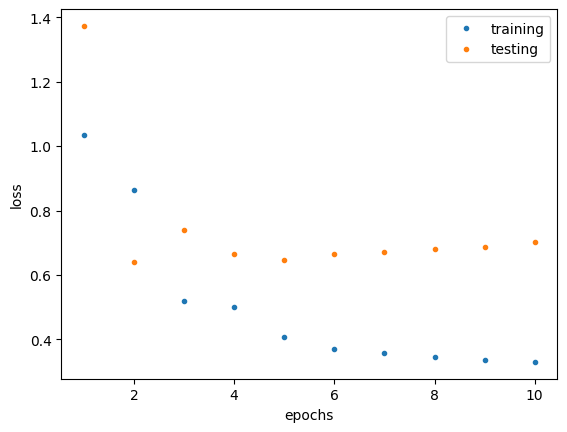

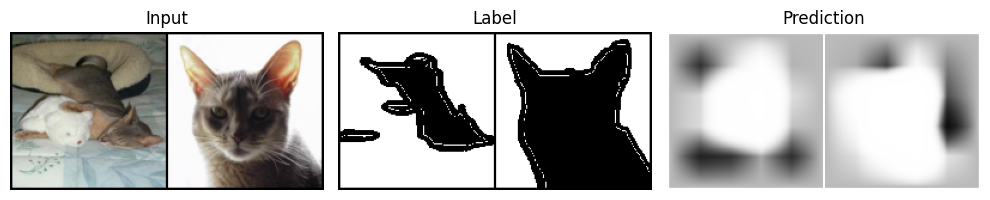

In [158]:
#import utils
import os
import sys
import json

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
from torchvision.transforms import PILToTensor, ToTensor, ToPILImage, Resize

#from torchvision.models import vgg16, VGG16_Weights

#from model import FCN32
#import traintestfuncs

#from test import show_output, test_model, show_uncertainity_map

###############################################################################
# general Parameters for training (make adjustments here)
###############################################################################
# Path for notebook
ROOTPATH = "/content/drive/MyDrive/Deep_learning_home_exam/data/problem2/"

# Path for local
#ROOTPATH = "home_exam\data\problem2\\"

# for saving model with trained parameters
VERSION = "02"

MODE = "train" # "train" or "evaluate"

# parameters for training (only for mode "train")
NUMBEREPOCHS = 10
BATCHSIZE = 2
LEARNINGRATE = 0.001

# resize dataset to see faster runtrough
SMALLDATASET = True
smaller_train_dataset_size = 10
smaller_test_dataset_size = 10


# resizing images of dataset so that they all have the same size
# (which they originaly dont have)
RESIZE =(128,128)
# 56 too small
#  128 #TODO
# 256 ok -> version 01
# resize to smaller images (not really good)

# bigger image better, together with drop of last two maxpool layers

# resize to smaller image maybe
# use kernelsize 7x7 in last step of convolution output
# google collab train on

PRETRAINED = True
SMALLVGG = False

model = FCN32(output_size=RESIZE, num_classes=2, small_vgg = SMALLVGG)

lossFunction = nn.CrossEntropyLoss() #nn.MSELoss()

Optimizer = optim.Adam(model.parameters(),lr = LEARNINGRATE) #optim.SGD()

# maybe only train last part
# turn grad of pre layers off

#for name, param in model.named_parameters():
#    print(name, param.requires_grad)



print("\n------------------------------------------------------------------\n")

###############################################################################
# directory for output files for model version / loading model
###############################################################################

foldername = "FCN_v" + VERSION + "/"
FOLDERPATH = os.path.join(ROOTPATH, foldername)

###############################################################################
# save parameters of model
###############################################################################

if MODE == "train":
  if not os.path.exists(FOLDERPATH):
    os.mkdir(FOLDERPATH)

    parameters = {"Modelversion" : VERSION,
                  "Batchsize" : BATCHSIZE,
                  "Learningrate" : LEARNINGRATE,
                  "Number Epochs" : NUMBEREPOCHS,
                  "Image resize" : RESIZE,
                  "untouched pretrained weights" : PRETRAINED,
                  "Smaller VGG" : SMALLVGG,
                  "Optimizer" : str(Optimizer),
                  "Model architectur" : str(model)}

    with open(FOLDERPATH + "training_parameters.json", 'w') as file:
      json.dump(parameters, file)

    print("File with trainingparameters of model saved in {}.".format(FOLDERPATH))
    print("\n------------------------------------------------------------------\n")

  else:
    test = 1
    #sys.exit("Folder for model allready exists.")

###############################################################################
# reload model for evaluation
###############################################################################

if MODE == "evaluate":

  if not os.path.exists(os.path.join(FOLDERPATH + "training_parameters.json")):
    sys.exit("File with parameters doesnt exists")

  with open(FOLDERPATH + "training_parameters.json", newline='') as file:
    parameters = json.load(file)

  VERSION = parameters["Modelversion"]
  BATCHSIZE = parameters["Batchsize"]
  LEARNINGRATE = parameters["Learningrate"]
  NUMBEREPOCHS = parameters["Number Epochs"]
  RESIZE = parameters["Image resize"]
  PRETRAINED = parameters["untouched pretrained weights"]
  SMALLVGG = parameters["Smaller VGG"]

  print("Loaded model version {} for evaluation".format(VERSION))
  print("\n------------------------------------------------------------------\n")

###############################################################################
# load dataset for training
###############################################################################

# open training data, has 3680 samples
# transform images (input images and lapels / mregion maps)to same sizes
pets_train = OxfordIIITPet(root=ROOTPATH, split="trainval",
                           transform =Resize(RESIZE),
                           target_transform = Resize(RESIZE),
                           target_types="segmentation", download=False)

# open test data, has 3669 samples
# transform images (input images and lapels / mregion maps)to same sizes
pets_test = OxfordIIITPet(root=ROOTPATH, split="test",
                          transform = Resize(RESIZE),
                          target_transform = Resize(RESIZE),
                          target_types="segmentation", download=False)

# use smaller dataset for faster runntime during debugging
if SMALLDATASET:
    print("Use reduced size of dataset for faster runtime. ONLY FOR DEBUGGING!\n")
    pets_train = smallerDataset(pets_train, smaller_train_dataset_size)
    pets_test = smallerDataset(pets_test, smaller_test_dataset_size)

# load data for training, use custom collate function
# to handle non-tensor format of original dataset
train_dataload = DataLoader(pets_train, batch_size=BATCHSIZE,
                            shuffle=True,
                            collate_fn= lambda b, params=RESIZE: customCollate(b, params))

# load data for testing, use custom collate function
# to handle non-tensor format of original dataset
test_dataload = DataLoader(pets_test, batch_size=BATCHSIZE,
                           shuffle=True,
                           collate_fn= lambda b, params=RESIZE: customCollate(b, params))

print("Dataset loaded.")
print("\n------------------------------------------------------------------\n")

###############################################################################
# training and testing
###############################################################################

if MODE == "train":
  print("Starting training.")

  if PRETRAINED:
    print("Dont train pretrained weights of the VGG16 features.")
    for param in model.features.parameters():
      param.requires_grad = False

  training_loss, test_loss = trainModel(model, lossFunction, Optimizer,
                                        train_dataload, test_dataload,
                                        NUMBEREPOCHS, FOLDERPATH)

  plotLosses(training_loss, test_loss, FOLDERPATH)

  _, last_dataset = testModel(model, lossFunction, test_dataload)

  visualizeOutputs(*last_dataset, FOLDERPATH)

  print("Finished training.")
  print("\n------------------------------------------------------------------\n")

###############################################################################
# only evaluation
###############################################################################

if MODE == "evaluate":
  print("Starting evaluation.")


  print("\nFinished evaluation.")
  print("\n------------------------------------------------------------------\n")




In [237]:
def visualizeOutputs(test_images, test_labels, test_labels_orig,
                     output, FOLDERPATH):

  # recover explizit color channel for plotting
  test_labels = test_labels.view(test_labels.shape[0], 1,
                                 test_labels.shape[1], test_labels.shape[2])

  # use softmax here or after last layer?
  output = nn.Softmax(dim=1)(output)

  threshold = 0.5 #change / play around here?

  #print(torch.unique(output[0,0,:,:]))# values between 0 and 1
  #print(torch.unique(output[0,1,:,:]))


  #print(tmp.shape)
  tmp = torch.where(output[:,0,:,:] > threshold, 0.0 , 1.0)
  tmp = tmp.view([output.shape[0], 1, output.shape[2],
                     output.shape[3]])

  # with color then transitions better shown?
  #tmp[:,0,:,:] = output[:,0,:,:]
  #tmp[:,1,:,:] = output[:,1,:,:]

  output = tmp
  #print(output.shape)

  grid_1 = ToPILImage()(make_grid(test_images))
  grid_2 = ToPILImage()(make_grid(test_labels.float()))
  grid_3 = ToPILImage()(make_grid(output))

  fig, ax = plt.subplots(nrows=1, ncols=3, figsize =(10,6))
  ax[0].imshow(grid_1)
  ax[0].set_title("Input")
  ax[0].axis("off")
  ax[1].imshow(grid_2, cmap = "gray")
  ax[1].set_title("Label")
  ax[1].axis("off")
  ax[2].imshow(grid_3)#, cmap = "grey")
  ax[2].set_title("Prediction")
  ax[2].axis("off")
  fig.tight_layout()
  plt.savefig(FOLDERPATH + "output_visualisation.png")

  return()

()

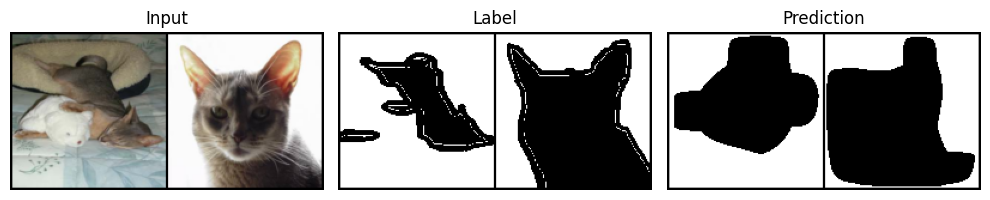

In [238]:
visualizeOutputs(*last_dataset, FOLDERPATH)